In [17]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
import matplotlib.dates as mdates
import statsmodels.formula.api as smf

In [51]:
df = pd.read_csv('FullDataset.csv')
df = df[df['link'].str.contains('https://www.tccb.gov.tr/konusmalar/', na=False)]
df = df[df["notes"] != "message"]
for index, row in df.iterrows():
    if 'opening ceremony' in row['title'].lower() and row['context'] is not None:
        df.loc[index, 'context'] = 'Opening Ceremony'

df = df.loc[df['context'].isin(['Speech After the Cabinet Meeting',
                                'AKP Group Talk',
                                'Grand National Assembly Opening',
                                'National Address',
                                'Public Address',
                                'Republic Day',
                                "Martyrs' Day",
                                'Ataturk Commemoration',
                                'Manzikert Victory',
                                "Children's Day",
                                'Opening Ceremony',
                                'Anniversary of the Conquest of Istanbul'])]

## Date Erdogan swore his oath to be president
oath_of_office = datetime.datetime.strptime('2014-08-28', "%Y-%m-%d")
## Date all proposed ammendments to the constitution approved by parliament
ammendments_approved = datetime.datetime.strptime('2017-01-20', "%Y-%m-%d")
## Date of the national referendum
referendum_vote = datetime.datetime.strptime('2017-04-16', "%Y-%m-%d")
## Date the referendum too effect
effect = datetime.datetime.strptime('2019-03-19', "%Y-%m-%d")

df['datetime'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.loc[df['datetime'] >= oath_of_office]
df['referendum_binary'] = 0
df.loc[(df['datetime'] >= referendum_vote) & (df['datetime'] < effect), 'referendum_binary'] = 1
df['effect_binary'] = 0
df.loc[df['datetime'] >= effect, 'effect_binary'] = 1
df.to_csv('selected_speeches.csv')
print(df['context'].value_counts())

Opening Ceremony                           232
Speech After the Cabinet Meeting            60
AKP Group Talk                              37
Public Address                              16
Ataturk Commemoration                        7
Grand National Assembly Opening              6
Manzikert Victory                            4
National Address                             4
Martyrs' Day                                 4
Anniversary of the Conquest of Istanbul      3
Republic Day                                 3
Children's Day                               3
Name: context, dtype: int64


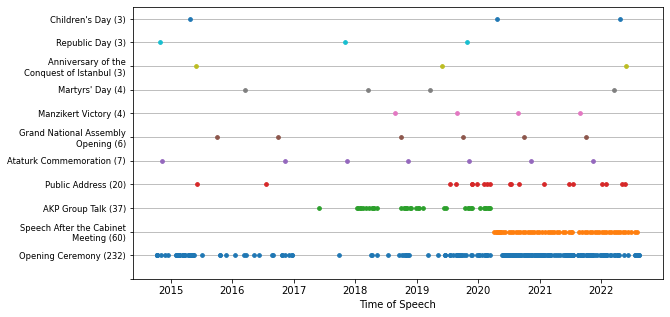

In [155]:
def num(date):
    return mdates.date2num(date)

df = pd.read_csv('selected_speeches.csv')
df['context'] = df['context'].replace(['National Address'], 'Public Address')

contexts = df['context'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(9.5, 5)
ax.set_axisbelow(True)
ax.grid(True, axis='y')

for index, context in enumerate(contexts.index):
    X = df[df['context'] == context]['datetime'].to_numpy()
    X = mdates.date2num(X)
    Y = np.full((1, len(X)), index + 1)
    ax.scatter(X, Y, label=context, s=14) #, color='tab:blue')

y_labels = []
events = contexts.index.to_list()
count = contexts.to_list()
for index, value in enumerate(events):
    y_labels.append('\n'.join(wrap(value + ' (' + str(count[index]) + ')', 25)))
y_labels.insert(0, "")
plt.yticks(range(len(y_labels)), y_labels, size='small')
xticks = pd.date_range(datetime.datetime(2014,8,28), datetime.datetime(2022,8,14), freq='1YS')
plt.xticks(xticks)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Time of Speech')
plt.savefig("DistributionOfSpeeches.pdf", bbox_inches='tight')
plt.show()


In [143]:
contexts.to_list()

[232, 60, 37, 20, 7, 6, 4, 4, 3, 3, 3]

In [20]:
df = pd.read_csv('selected_speeches.csv')
df['datetime'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

print(len(df.loc[df['datetime'] >= referendum_vote]))
print(len(df.loc[df['datetime'] < referendum_vote]))
print(len(df.index))

319
60
379


In [21]:
df = pd.read_csv('selected_speeches.csv')
def get_file_name(folder, file):
    return "{folder}/{file}".format(folder = folder, file = file)
    
df[df['context'] == context]
count = 0
total = 0
for index, row in df.iterrows():
    if row['context'] != 'AKP Group Talk':
        continue
    speech_file_name = get_file_name(row["folder"], row["file"])
    text_file = open(speech_file_name, "r", encoding="mbcs")
    speech = (text_file.read()).lower()
    if 'dear nation' in speech:
        count += 1
    # else:
    #     print(row['file'])
    total += 1
print(count, total, count/total)


22 37 0.5945945945945946


[Timestamp('2014-10-10 00:00:00'), datetime.datetime(2017, 4, 16, 0, 0), datetime.datetime(2019, 3, 19, 0, 0), Timestamp('2022-08-12 00:00:00')]


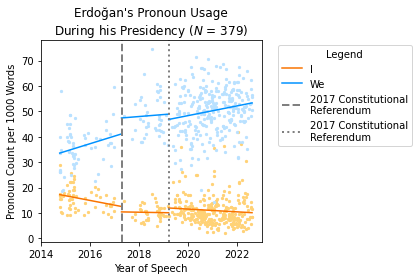

In [36]:
df = pd.read_csv('selected_speeches.csv')

start, end = 2014, 2023
df['datetime'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
all_dates = df["datetime"].to_list()

oldest_date, newest_date = min(all_dates), max(all_dates)
important_dates = [oldest_date, referendum_vote, effect, newest_date]
print(important_dates)
important_dates = [mdates.date2num(date) for date in important_dates]

for key in list(['I', 'We']):
    label = key
    light_color = "#b9e1ff"
    dark_color = "#0092ff"
    if (key == "I"):
        light_color = "#ffd276"
        dark_color = "#f97300"

    plt.scatter(df['datetime'].to_list(), df[key].to_list(), label='_nolegend_', color = light_color, s = 5)
    total_len = 0
    for index, lower_bound in enumerate(important_dates):
        if (index == len(important_dates) - 1):
            break
        upper_bound = important_dates[index + 1]
        # NOTE: regressions are counting points twice because both are <=
        y = df.loc[(mdates.date2num(df['datetime']) <= upper_bound) & (mdates.date2num(df['datetime']) >= lower_bound) ][key].to_list()
        x = df.loc[(mdates.date2num(df['datetime']) <= upper_bound) & (mdates.date2num(df['datetime']) >= lower_bound)]["datetime"].to_list()

        # new_x_y = avg_and_del_duplicates(x.copy(), y.copy(), aggregate_by)
        # x_fixed, y_fixed = new_x_y[0], new_x_y[1]
        m, b = np.polyfit(mdates.date2num(x), y, 1)

        plt.plot([lower_bound, upper_bound - 1], m*np.array([lower_bound, upper_bound])+b, label= label, color=dark_color)

        label = "_nolegend_"
        total_len += len(x)
        
label = '\n'.join(wrap('2017 Constitutional Referendum', 20))
plt.axvline(x=referendum_vote, ymin=0, ymax=1, color='grey', ls='--', lw=2, label=label)

label = '\n'.join(wrap('2017 Constitutional Referendum', 20))
plt.axvline(x=effect, ymin=0, ymax=1, color='grey', ls=':', lw=2, label=label)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend(title="Legend", bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Erdoğan's Pronoun Usage\nDuring his Presidency ($\it{N}$ = " + str(total_len) + ")")
plt.xlabel("Year of Speech")
xticks = pd.date_range(datetime.datetime(start,1,1), datetime.datetime(end,1,1), freq='2YS')
plt.xticks(xticks)
plt.ylabel("Pronoun Count per 1000 Words")
plt.tight_layout()
plt.show()

In [135]:
df['datetime'] =  mdates.date2num(pd.to_datetime(df['date'], format='%d.%m.%Y'))
df['datetime2'] =  df['datetime'] - mdates.date2num(oath_of_office)

df['I_we'] = df['I/We']
# results = smf.ols('We ~ datetime + referendum_binary + datetime*referendum_binary + effect_binary + datetime*effect_binary + Covid', data=df).fit()
# print(results.summary())

results = smf.ols('I_we ~ datetime2 + referendum_binary + referendum_binary*datetime2 + effect_binary + datetime2*effect_binary + Covid', data=df).fit()
# print(results.summary)
res_df = results.summary2().tables[1]
res_df.loc['datetime2', 'Coef.'] = res_df.loc['datetime2', 'Coef.'] * 365
res_df.loc['referendum_binary:datetime2', 'Coef.'] = res_df.loc['referendum_binary:datetime2', 'Coef.'] * 365
res_df.loc['datetime2:effect_binary', 'Coef.'] = res_df.loc['datetime2:effect_binary', 'Coef.'] * 365
res_df.loc['datetime2', 'Std.Err.'] = res_df.loc['datetime2', 'Std.Err.'] * 365
res_df.loc['referendum_binary:datetime2', 'Std.Err.'] = res_df.loc['referendum_binary:datetime2', 'Std.Err.'] * 365
res_df.loc['datetime2:effect_binary', 'Std.Err.'] = res_df.loc['datetime2:effect_binary', 'Std.Err.'] * 365
# print(res_df[['Coef.', 'Std.Err.']])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   I_we   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     22.27
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           2.06e-22
Time:                        00:55:42   Log-Likelihood:                 131.68
No. Observations:                 379   AIC:                            -249.4
Df Residuals:                     372   BIC:                            -221.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [66]:
mdates.date2num(newest_date)
res_df = results.summary2().tables[1]
res_df.loc['Intercept', 'Coef.']

17.411045126308426

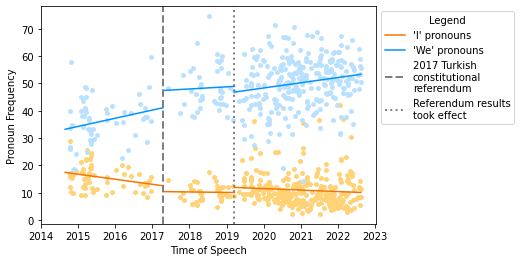

In [101]:
df['datetime'] =  mdates.date2num(pd.to_datetime(df['date'], format='%d.%m.%Y'))
df['datetime2'] =  df['datetime']# - mdates.date2num(oath_of_office)

df['I_we_ratio'] = df['I/We']

results = smf.ols('I ~ datetime2 + referendum_binary + referendum_binary*datetime2 + effect_binary + datetime2*effect_binary', data=df).fit()
# print(results.summary)
res_df = results.summary2().tables[1]
min = 16310.0 #- 16310.0
max = 19216.0 #- 16310.0
referendum = mdates.date2num(referendum_vote)

def func_plot(date, ref_binary, effect_binary, res_df):
    return (res_df.loc['Intercept', 'Coef.'] + res_df.loc['datetime2', 'Coef.']*date 
        + res_df.loc['referendum_binary', 'Coef.']*ref_binary + res_df.loc['referendum_binary:datetime2', 'Coef.']*ref_binary*date 
        + res_df.loc['effect_binary', 'Coef.']*effect_binary + res_df.loc['datetime2:effect_binary', 'Coef.']*effect_binary*date)

light_color = "#ffd276"
dark_color = "#f97300"       
plt.plot( [min, referendum], [func_plot(min, 0, 0, res_df), func_plot(referendum, 0, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot( [referendum, mdates.date2num(effect)], [func_plot(referendum, 1, 0, res_df), func_plot(mdates.date2num(effect), 1, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot([mdates.date2num(effect), max], [func_plot(mdates.date2num(effect), 0, 1, res_df), func_plot(max, 0, 1, res_df)], label = "'I' pronouns", color=dark_color)
plt.scatter(df["datetime2"].to_list(), df["I"].to_list(), label='_nolegend_', color = light_color, s=15)

results = smf.ols('We ~ datetime2 + referendum_binary + referendum_binary*datetime2 + effect_binary + datetime2*effect_binary', data=df).fit()
# print(results.summary)
res_df = results.summary2().tables[1]

light_color = "#b9e1ff"
dark_color = "#0092ff"

plt.plot( [min, referendum], [func_plot(min, 0, 0, res_df), func_plot(referendum, 0, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot( [referendum, mdates.date2num(effect)], [func_plot(referendum, 1, 0, res_df), func_plot(mdates.date2num(effect), 1, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot([mdates.date2num(effect), max], [func_plot(mdates.date2num(effect), 0, 1, res_df), func_plot(max, 0, 1, res_df)], label = "'We' pronouns", color=dark_color)
plt.scatter(df["datetime2"].to_list(), df["We"].to_list(), label='_nolegend_', color = light_color, s=15)

label = '\n'.join(wrap('2017 Turkish constitutional referendum', 20))
plt.axvline(x=referendum_vote, ymin=0, ymax=1, color='grey', ls='--', lw=2, label=label)

label = '\n'.join(wrap('Referendum results took effect', 20))
plt.axvline(x=effect, ymin=0, ymax=1, color='grey', ls=':', lw=2, label=label)

plt.legend(title="Legend", bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.xlabel("Time of Speech")
plt.ylabel("Pronoun Frequency")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

start, end = 2014, 2023

xticks = pd.date_range(datetime.datetime(start,1,1), datetime.datetime(end,1,1), freq='YS')
plt.xticks(xticks)# plt(x2, y2, 'bo')
plt.savefig("FrequencyAppendix.pdf", bbox_inches='tight')


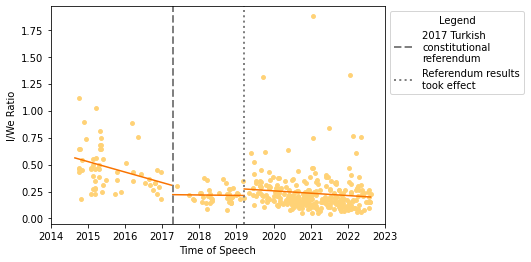

In [100]:
df['datetime'] =  mdates.date2num(pd.to_datetime(df['date'], format='%d.%m.%Y'))
df['datetime2'] =  df['datetime']# - mdates.date2num(oath_of_office)

df['I_we_ratio'] = df['I/We']

results = smf.ols('I_we_ratio ~ datetime2 + referendum_binary + referendum_binary*datetime2 + effect_binary + datetime2*effect_binary', data=df).fit()
# print(results.summary)
res_df = results.summary2().tables[1]
min = 16310.0 #- 16310.0
max = 19216.0 #- 16310.0
referendum = mdates.date2num(referendum_vote)

def func_plot(date, ref_binary, effect_binary, res_df):
    return (res_df.loc['Intercept', 'Coef.'] + res_df.loc['datetime2', 'Coef.']*date 
        + res_df.loc['referendum_binary', 'Coef.']*ref_binary + res_df.loc['referendum_binary:datetime2', 'Coef.']*ref_binary*date 
        + res_df.loc['effect_binary', 'Coef.']*effect_binary + res_df.loc['datetime2:effect_binary', 'Coef.']*effect_binary*date)

light_color = "#ffd276"
dark_color = "#f97300"       
plt.plot( [min, referendum], [func_plot(min, 0, 0, res_df), func_plot(referendum, 0, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot( [referendum, mdates.date2num(effect)], [func_plot(referendum, 1, 0, res_df), func_plot(mdates.date2num(effect), 1, 0, res_df)], label = "_nolegend_", color=dark_color)
plt.plot([mdates.date2num(effect), max], [func_plot(mdates.date2num(effect), 0, 1, res_df), func_plot(max, 0, 1, res_df)], label = "_nolegend_", color=dark_color)
plt.scatter(df["datetime2"].to_list(), df["I_we_ratio"].to_list(), label='_nolegend_', color = light_color, s=15)

label = '\n'.join(wrap('2017 Turkish constitutional referendum', 20))
plt.axvline(x=referendum_vote, ymin=0, ymax=1, color='grey', ls='--', lw=2, label=label)

label = '\n'.join(wrap('Referendum results took effect', 20))
plt.axvline(x=effect, ymin=0, ymax=1, color='grey', ls=':', lw=2, label=label)

plt.legend(title="Legend", bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.xlabel("Time of Speech")
plt.ylabel("I/We Ratio")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

start, end = 2014, 2023

xticks = pd.date_range(datetime.datetime(start,1,1), datetime.datetime(end,1,1), freq='YS')
plt.xticks(xticks)# plt(x2, y2, 'bo')
plt.savefig("RatioAppendix.pdf", bbox_inches='tight')
